In [ ]:
import gymnasium as gym # <--- Use gymnasium
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import defaultdict
import time
from tqdm.notebook import tqdm # For progress bars

# Set seeds for reproducibility (optional but recommended)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
# rng = np.random.default_rng(SEED) # Alternative modern way

# Set seaborn plotting style
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style("whitegrid")

In [ ]:
def choose_action_epsilon_greedy(q_table, state, epsilon, action_space):
    """Chooses an action using the epsilon-greedy strategy."""
    # Use numpy's random generator is usually preferred in RL contexts
    if np.random.rand() < epsilon:
         # Explore: Sample a random action from the environment's action space
        return action_space.sample()
    else:
        # Exploit: Choose the action with the highest Q-value.
        # Handle ties by choosing randomly among the best actions.
        q_values = q_table[state]
        max_q = np.max(q_values)
        # Find all indices where the Q-value equals the maximum
        best_actions = np.where(q_values == max_q)[0]
        # Choose one randomly from the best actions
        return np.random.choice(best_actions)

In [ ]:
def evaluate_policy(env, q_table, eval_episodes=50, eval_seed_base=123):
    """Evaluates the current policy (greedy w.r.t. Q-table) for a number of episodes."""
    total_rewards = 0.0
    # action_space = env.action_space # Get action space from env

    for i in range(eval_episodes):
        # Seed the reset for reproducible evaluation episodes
        state, info = env.reset(seed=eval_seed_base + i)
        terminated = False
        truncated = False
        episode_reward = 0.0

        while not (terminated or truncated):
            # Choose action greedily (epsilon = 0)
            action = np.argmax(q_table[state]) # Simple argmax is fine for greedy
            # Use new step API
            next_state, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            state = next_state # Update state

        total_rewards += episode_reward

    return total_rewards / eval_episodes

In [ ]:
def q_learning_train(env, num_episodes, alpha, gamma, epsilon, eval_interval=100, eval_episodes=50):
    """Trains an agent using the Q-Learning algorithm."""
    # Use observation/action space from env
    n_states = env.observation_space.n
    action_space = env.action_space
    q_table = np.zeros((n_states, action_space.n))
    evaluation_rewards = [] # Store pairs of (episode, avg_reward)

    print(f"Starting Q-Learning Training (α={alpha}, γ={gamma}, ε={epsilon})...")
    for episode in tqdm(range(1, num_episodes + 1)):
        # Use new reset API, no seed needed here for diverse training
        state, info = env.reset()
        terminated = False
        truncated = False

        while not (terminated or truncated):
            action = choose_action_epsilon_greedy(q_table, state, epsilon, action_space)
            # Use new step API
            next_state, reward, terminated, truncated, info = env.step(action)

            # Q-Learning update rule
            best_next_action_value = np.max(q_table[next_state]) # Max over actions in next state
            td_target = reward + gamma * best_next_action_value * (1 - terminated) # No value if terminated
            td_error = td_target - q_table[state, action]
            q_table[state, action] += alpha * td_error

            state = next_state # Move to the next state

        # Evaluate the policy periodically
        if episode % eval_interval == 0:
            # Pass the evaluation seed base
            avg_reward = evaluate_policy(env, q_table, eval_episodes, eval_seed_base=episode) # Use episode number for unique eval seed
            evaluation_rewards.append((episode, avg_reward))

    print("Q-Learning Training finished.")
    return q_table, evaluation_rewards

In [ ]:
def sarsa_train(env, num_episodes, alpha, gamma, epsilon, eval_interval=100, eval_episodes=50):
    """Trains an agent using the SARSA algorithm."""
    n_states = env.observation_space.n
    action_space = env.action_space
    q_table = np.zeros((n_states, action_space.n))
    evaluation_rewards = [] # Store pairs of (episode, avg_reward)

    print(f"Starting SARSA Training (α={alpha}, γ={gamma}, ε={epsilon})...")
    for episode in tqdm(range(1, num_episodes + 1)):
        # Use new reset API
        state, info = env.reset()
        action = choose_action_epsilon_greedy(q_table, state, epsilon, action_space)
        terminated = False
        truncated = False

        while not (terminated or truncated):
            # Use new step API
            next_state, reward, terminated, truncated, info = env.step(action)
            # Choose next_action *before* updating Q-table
            next_action = choose_action_epsilon_greedy(q_table, next_state, epsilon, action_space)

            # SARSA update rule
            # Use the Q-value of the *actually chosen* next action
            td_target = reward + gamma * q_table[next_state, next_action] * (1 - terminated) # No value if terminated
            td_error = td_target - q_table[state, action]
            q_table[state, action] += alpha * td_error

            state = next_state
            action = next_action # Crucial difference: update action for next iteration

        # Evaluate the policy periodically
        if episode % eval_interval == 0:
            avg_reward = evaluate_policy(env, q_table, eval_episodes, eval_seed_base=episode)
            evaluation_rewards.append((episode, avg_reward))

    print("SARSA Training finished.")
    return q_table, evaluation_rewards

In [ ]:
ENV_NAMES = ['Taxi-v3', 'FrozenLake-v1']
NUM_EPISODES = 15000  # Increased episodes for potentially harder FrozenLake
EVAL_INTERVAL = 100
EVAL_EPISODES = 50

# Hyperparameters to vary
GAMMAS = [0.5, 0.9]
EPSILONS = [0.1, 0.5, 0.8]
ALPHAS = [0.1, 0.5, 0.9]

# Baseline/Default parameters (use one combination for initial comparison)
BASELINE_GAMMA = 0.9
BASELINE_EPSILON = 0.1
BASELINE_ALPHA = 0.5

# Store results
# Structure: results[env_name][algorithm][param_varied][param_value] = evaluation_rewards
# Make sure defaultdict is imported: from collections import defaultdict
results = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list))))

# Make sure gym is imported as gymnasium
import gymnasium as gym
from collections import defaultdict # Ensure this import is present

# Make sure SEED is defined if you are using it for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
for env_name in ENV_NAMES:
    print(f"\n----- Running experiments for Environment: {env_name} -----")
    # Use gymnasium.make
    # Render mode can be added: render_mode="rgb_array" or "human" if needed later
    env = gym.make(env_name)
    # env.seed(42) # <--- REMOVE THIS LINE

    # --- Baseline Comparison ---
    print("\n--- Baseline Comparison ---")
    print(f"Params: γ={BASELINE_GAMMA}, ε={BASELINE_EPSILON}, α={BASELINE_ALPHA}")
    _, ql_rewards = q_learning_train(env, NUM_EPISODES, BASELINE_ALPHA, BASELINE_GAMMA, BASELINE_EPSILON, EVAL_INTERVAL, EVAL_EPISODES)
    _, sarsa_rewards = sarsa_train(env, NUM_EPISODES, BASELINE_ALPHA, BASELINE_GAMMA, BASELINE_EPSILON, EVAL_INTERVAL, EVAL_EPISODES)
    results[env_name]['q_learning']['baseline']['baseline'] = ql_rewards
    results[env_name]['sarsa']['baseline']['baseline'] = sarsa_rewards

    # --- Varying Alpha ---
    print("\n--- Varying Alpha (α) ---")
    gamma = BASELINE_GAMMA
    epsilon = BASELINE_EPSILON
    for alpha in ALPHAS:
        print(f"Params: γ={gamma}, ε={epsilon}, α={alpha}")
        _, ql_rewards = q_learning_train(env, NUM_EPISODES, alpha, gamma, epsilon, EVAL_INTERVAL, EVAL_EPISODES)
        _, sarsa_rewards = sarsa_train(env, NUM_EPISODES, alpha, gamma, epsilon, EVAL_INTERVAL, EVAL_EPISODES)
        results[env_name]['q_learning']['alpha'][alpha] = ql_rewards
        results[env_name]['sarsa']['alpha'][alpha] = sarsa_rewards

    # --- Varying Gamma ---
    print("\n--- Varying Gamma (γ) ---")
    alpha = BASELINE_ALPHA
    epsilon = BASELINE_EPSILON
    for gamma in GAMMAS:
        print(f"Params: γ={gamma}, ε={epsilon}, α={alpha}")
        _, ql_rewards = q_learning_train(env, NUM_EPISODES, alpha, gamma, epsilon, EVAL_INTERVAL, EVAL_EPISODES)
        _, sarsa_rewards = sarsa_train(env, NUM_EPISODES, alpha, gamma, epsilon, EVAL_INTERVAL, EVAL_EPISODES)
        results[env_name]['q_learning']['gamma'][gamma] = ql_rewards
        results[env_name]['sarsa']['gamma'][gamma] = sarsa_rewards

    # --- Varying Epsilon ---
    print("\n--- Varying Epsilon (ε) ---")
    alpha = BASELINE_ALPHA
    gamma = BASELINE_GAMMA
    for epsilon in EPSILONS:
        print(f"Params: γ={gamma}, ε={epsilon}, α={alpha}")
        _, ql_rewards = q_learning_train(env, NUM_EPISODES, alpha, gamma, epsilon, EVAL_INTERVAL, EVAL_EPISODES)
        _, sarsa_rewards = sarsa_train(env, NUM_EPISODES, alpha, gamma, epsilon, EVAL_INTERVAL, EVAL_EPISODES)
        results[env_name]['q_learning']['epsilon'][epsilon] = ql_rewards
        results[env_name]['sarsa']['epsilon'][epsilon] = sarsa_rewards

    env.close() # Good practice to close the environment
print("\n----- All Experiments Completed -----")


----- Running experiments for Environment: Taxi-v3 -----

--- Baseline Comparison ---
Params: γ=0.9, ε=0.1, α=0.5
Starting Q-Learning Training (α=0.5, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

Q-Learning Training finished.
Starting SARSA Training (α=0.5, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

SARSA Training finished.

--- Varying Alpha (α) ---
Params: γ=0.9, ε=0.1, α=0.1
Starting Q-Learning Training (α=0.1, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

Q-Learning Training finished.
Starting SARSA Training (α=0.1, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

SARSA Training finished.
Params: γ=0.9, ε=0.1, α=0.5
Starting Q-Learning Training (α=0.5, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

Q-Learning Training finished.
Starting SARSA Training (α=0.5, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

SARSA Training finished.
Params: γ=0.9, ε=0.1, α=0.9
Starting Q-Learning Training (α=0.9, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

Q-Learning Training finished.
Starting SARSA Training (α=0.9, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

SARSA Training finished.

--- Varying Gamma (γ) ---
Params: γ=0.5, ε=0.1, α=0.5
Starting Q-Learning Training (α=0.5, γ=0.5, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

Q-Learning Training finished.
Starting SARSA Training (α=0.5, γ=0.5, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

SARSA Training finished.
Params: γ=0.9, ε=0.1, α=0.5
Starting Q-Learning Training (α=0.5, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

Q-Learning Training finished.
Starting SARSA Training (α=0.5, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

SARSA Training finished.

--- Varying Epsilon (ε) ---
Params: γ=0.9, ε=0.1, α=0.5
Starting Q-Learning Training (α=0.5, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

Q-Learning Training finished.
Starting SARSA Training (α=0.5, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

SARSA Training finished.
Params: γ=0.9, ε=0.5, α=0.5
Starting Q-Learning Training (α=0.5, γ=0.9, ε=0.5)...


  0%|          | 0/15000 [00:00<?, ?it/s]

Q-Learning Training finished.
Starting SARSA Training (α=0.5, γ=0.9, ε=0.5)...


  0%|          | 0/15000 [00:00<?, ?it/s]

SARSA Training finished.
Params: γ=0.9, ε=0.8, α=0.5
Starting Q-Learning Training (α=0.5, γ=0.9, ε=0.8)...


  0%|          | 0/15000 [00:00<?, ?it/s]

Q-Learning Training finished.
Starting SARSA Training (α=0.5, γ=0.9, ε=0.8)...


  0%|          | 0/15000 [00:00<?, ?it/s]

SARSA Training finished.

----- Running experiments for Environment: FrozenLake-v1 -----

--- Baseline Comparison ---
Params: γ=0.9, ε=0.1, α=0.5
Starting Q-Learning Training (α=0.5, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

Q-Learning Training finished.
Starting SARSA Training (α=0.5, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

SARSA Training finished.

--- Varying Alpha (α) ---
Params: γ=0.9, ε=0.1, α=0.1
Starting Q-Learning Training (α=0.1, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

Q-Learning Training finished.
Starting SARSA Training (α=0.1, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

SARSA Training finished.
Params: γ=0.9, ε=0.1, α=0.5
Starting Q-Learning Training (α=0.5, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

Q-Learning Training finished.
Starting SARSA Training (α=0.5, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

SARSA Training finished.
Params: γ=0.9, ε=0.1, α=0.9
Starting Q-Learning Training (α=0.9, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

Q-Learning Training finished.
Starting SARSA Training (α=0.9, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

SARSA Training finished.

--- Varying Gamma (γ) ---
Params: γ=0.5, ε=0.1, α=0.5
Starting Q-Learning Training (α=0.5, γ=0.5, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

Q-Learning Training finished.
Starting SARSA Training (α=0.5, γ=0.5, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

SARSA Training finished.
Params: γ=0.9, ε=0.1, α=0.5
Starting Q-Learning Training (α=0.5, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

Q-Learning Training finished.
Starting SARSA Training (α=0.5, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

SARSA Training finished.

--- Varying Epsilon (ε) ---
Params: γ=0.9, ε=0.1, α=0.5
Starting Q-Learning Training (α=0.5, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

Q-Learning Training finished.
Starting SARSA Training (α=0.5, γ=0.9, ε=0.1)...


  0%|          | 0/15000 [00:00<?, ?it/s]

SARSA Training finished.
Params: γ=0.9, ε=0.5, α=0.5
Starting Q-Learning Training (α=0.5, γ=0.9, ε=0.5)...


  0%|          | 0/15000 [00:00<?, ?it/s]

Q-Learning Training finished.
Starting SARSA Training (α=0.5, γ=0.9, ε=0.5)...


  0%|          | 0/15000 [00:00<?, ?it/s]

SARSA Training finished.
Params: γ=0.9, ε=0.8, α=0.5
Starting Q-Learning Training (α=0.5, γ=0.9, ε=0.8)...


  0%|          | 0/15000 [00:00<?, ?it/s]

Q-Learning Training finished.
Starting SARSA Training (α=0.5, γ=0.9, ε=0.8)...


  0%|          | 0/15000 [00:00<?, ?it/s]

SARSA Training finished.

----- All Experiments Completed -----


In [ ]:
def plot_comparison(results_dict, env_name, title_suffix=""):
    """Plots Q-Learning vs SARSA for baseline parameters."""
    plt.figure(figsize=(12, 7))
    ql_rewards = results_dict[env_name]['q_learning']['baseline']['baseline']
    sarsa_rewards = results_dict[env_name]['sarsa']['baseline']['baseline']

    if not ql_rewards or not sarsa_rewards:
        print(f"No baseline data to plot for {env_name}")
        return

    episodes_ql, avg_rewards_ql = zip(*ql_rewards)
    episodes_sarsa, avg_rewards_sarsa = zip(*sarsa_rewards)

    plt.plot(episodes_ql, avg_rewards_ql, label=f'Q-Learning (α={BASELINE_ALPHA}, γ={BASELINE_GAMMA}, ε={BASELINE_EPSILON})')
    plt.plot(episodes_sarsa, avg_rewards_sarsa, label=f'SARSA (α={BASELINE_ALPHA}, γ={BASELINE_GAMMA}, ε={BASELINE_EPSILON})')

    plt.xlabel("Training Episodes")
    plt.ylabel(f"Average Reward over {EVAL_EPISODES} Eval Episodes")
    plt.title(f"{env_name}: Q-Learning vs SARSA {title_suffix}")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_parameter_influence(results_dict, env_name, algorithm, param_name, fixed_params):
    """Plots the influence of varying one parameter for a given algorithm."""
    plt.figure(figsize=(12, 7))
    param_results = results_dict[env_name][algorithm][param_name]

    if not param_results:
        print(f"No data to plot for {env_name}, {algorithm}, varying {param_name}")
        return

    fixed_str = ", ".join([f"{k}={v}" for k, v in fixed_params.items()])

    for param_value, eval_rewards in param_results.items():
        if eval_rewards:
            episodes, avg_rewards = zip(*eval_rewards)
            plt.plot(episodes, avg_rewards, label=f'{param_name}={param_value}')

    plt.xlabel("Training Episodes")
    plt.ylabel(f"Average Reward over {EVAL_EPISODES} Eval Episodes")
    plt.title(f"{env_name} ({algorithm.upper()}): Influence of {param_name.upper()} (Fixed: {fixed_str})")
    plt.legend()
    plt.grid(True)
    plt.show()



----- Visualizing Results for: Taxi-v3 -----


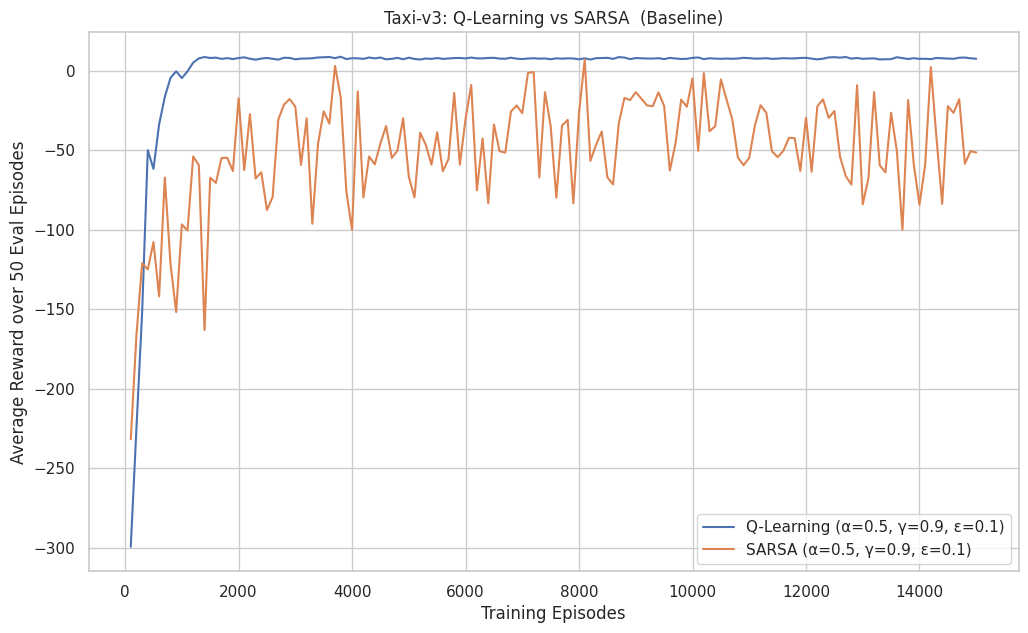

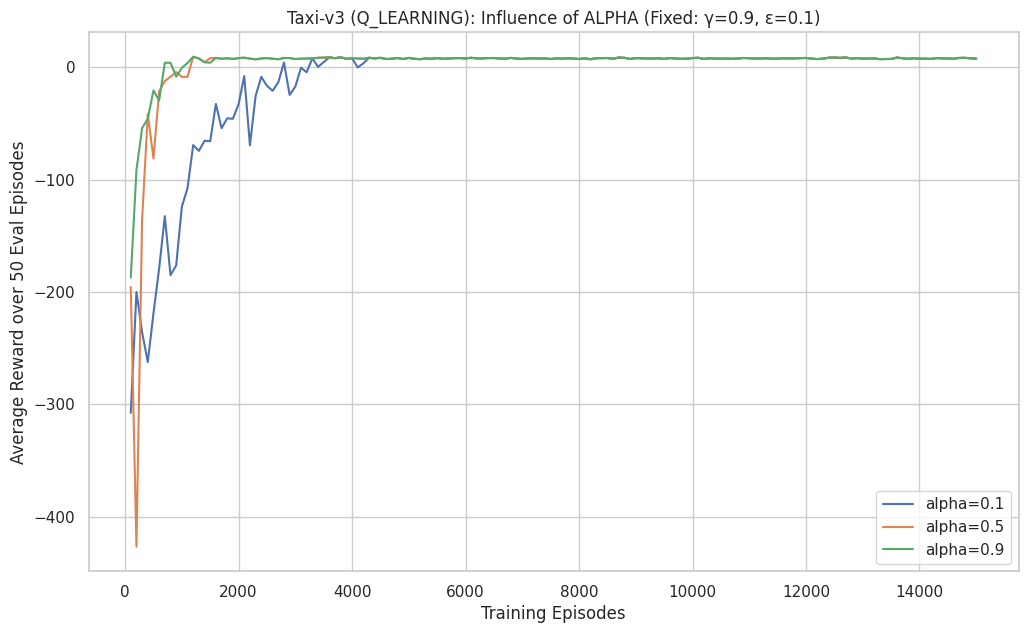

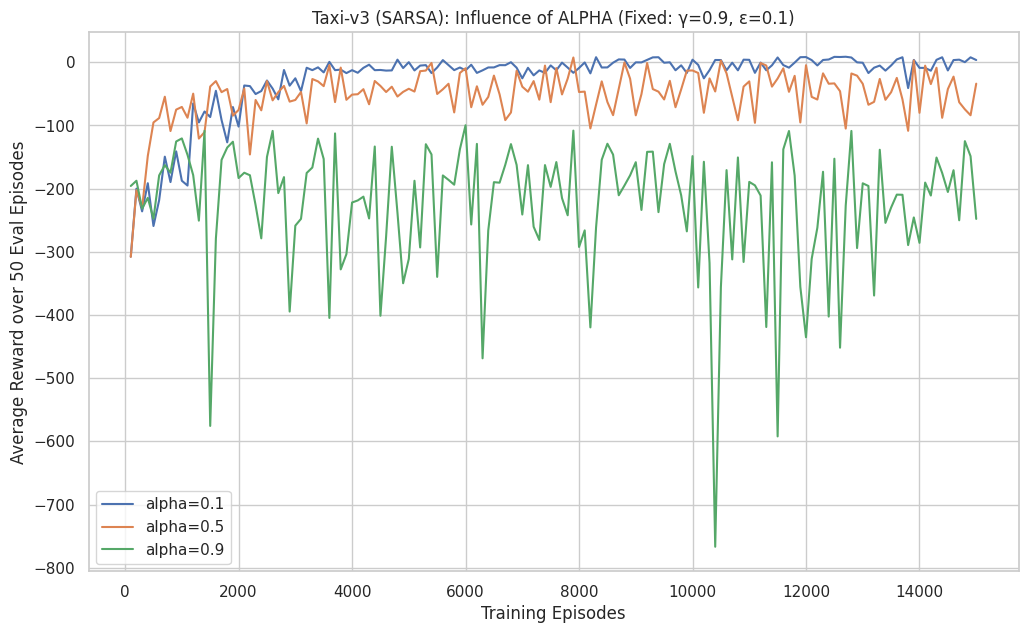

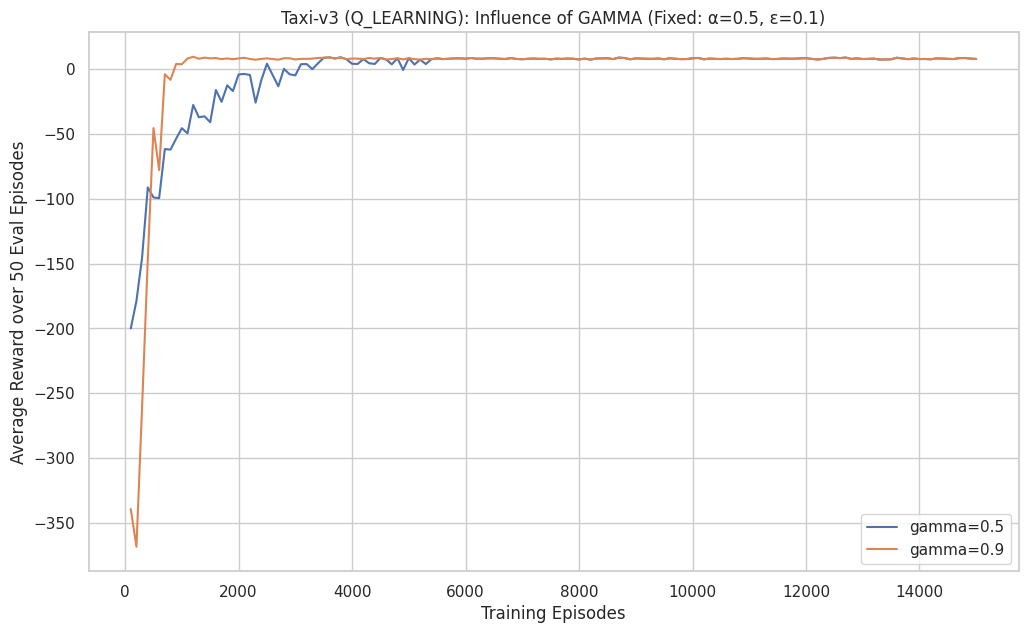

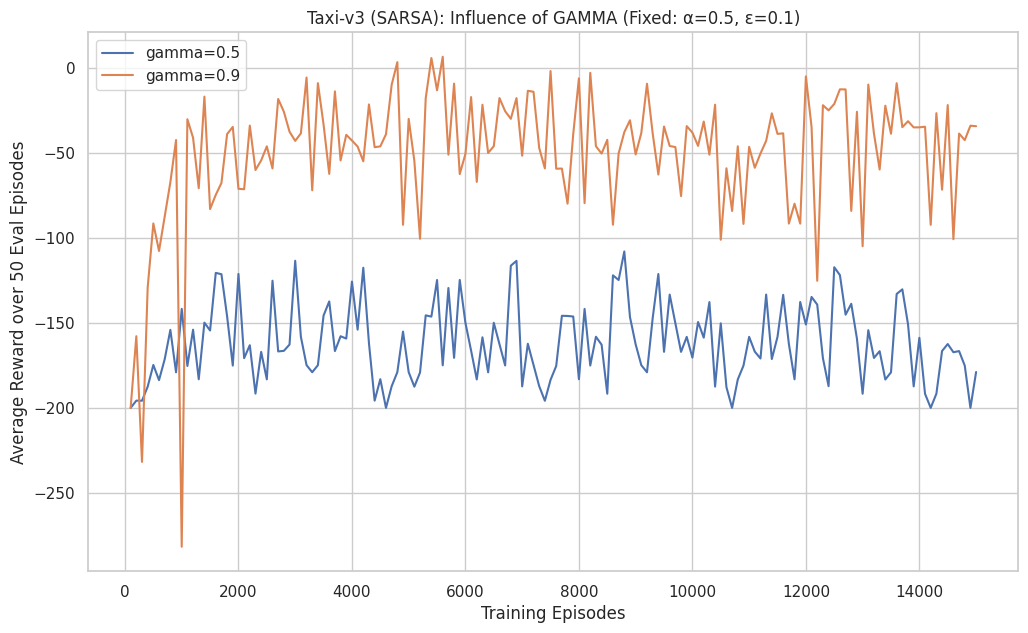

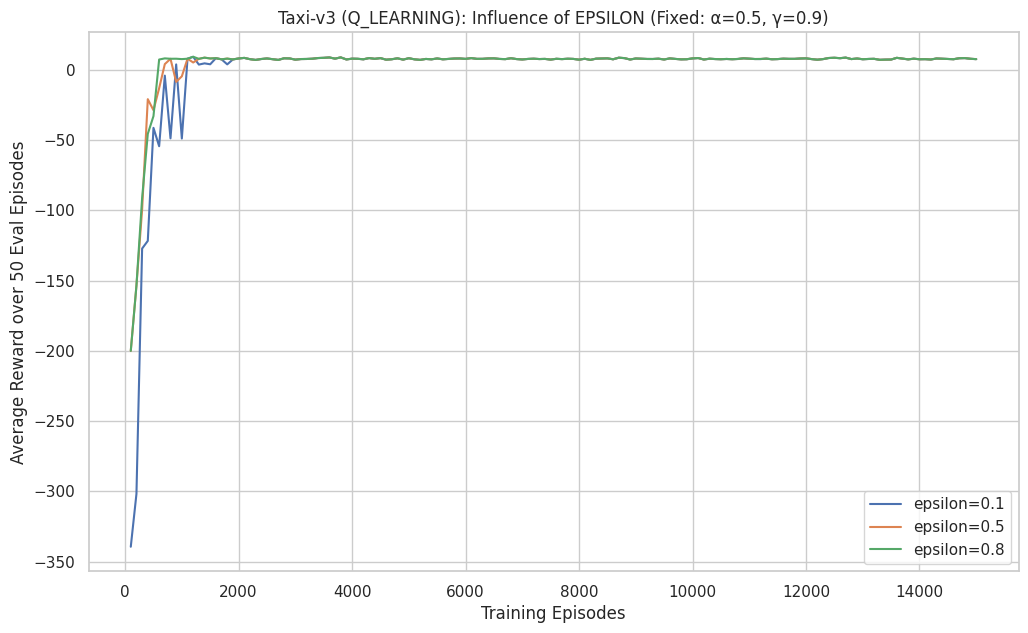

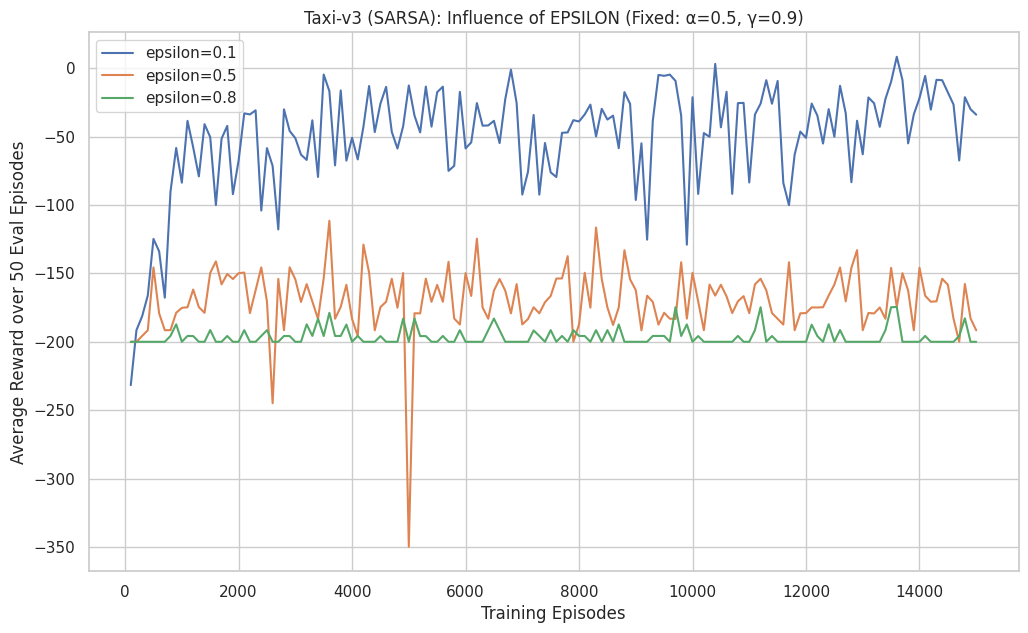


----- Visualizing Results for: FrozenLake-v1 -----


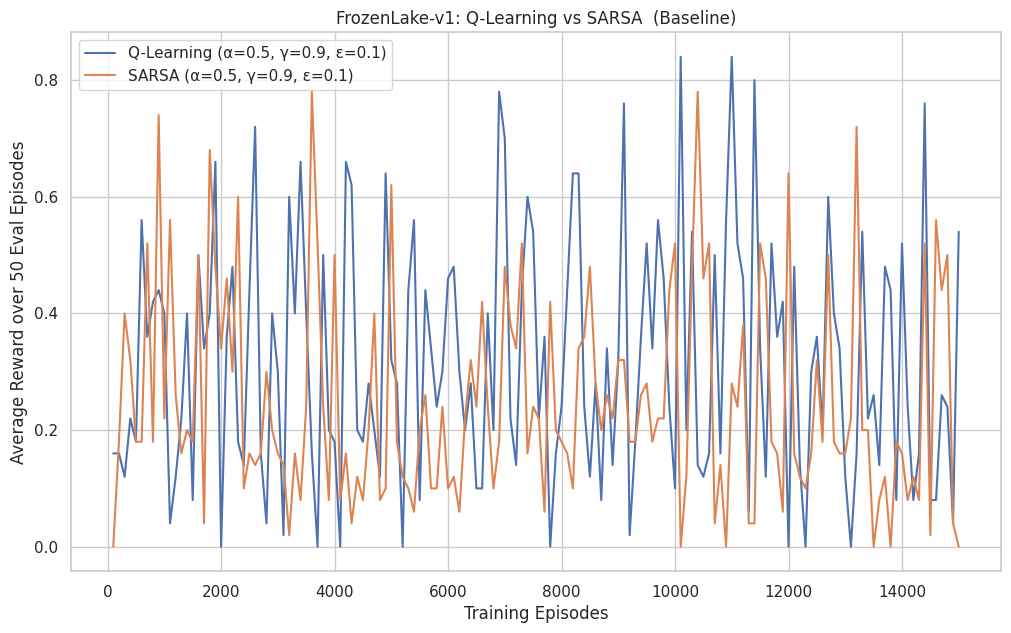

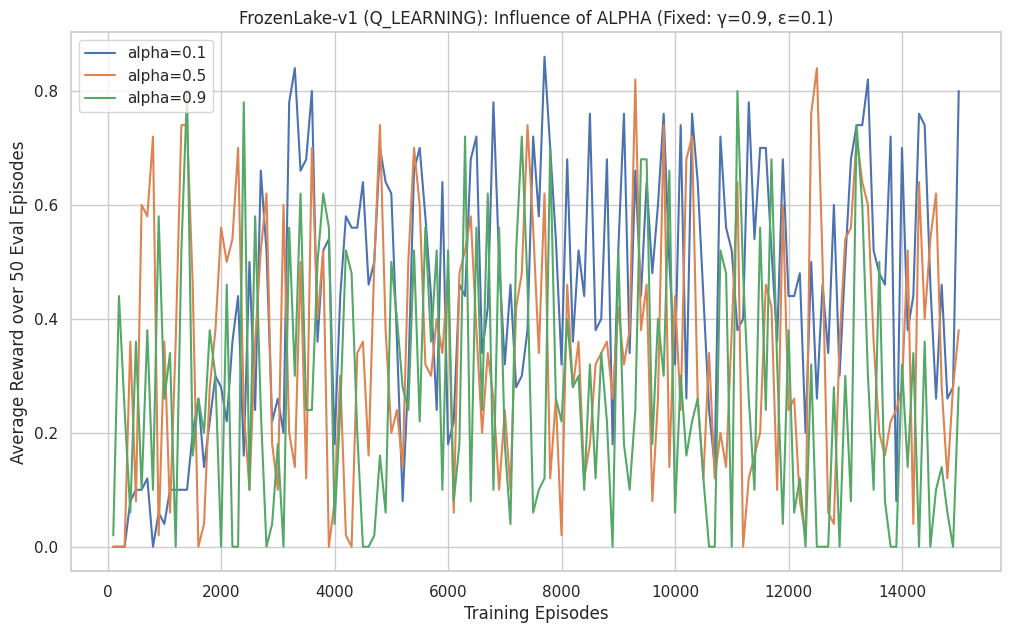

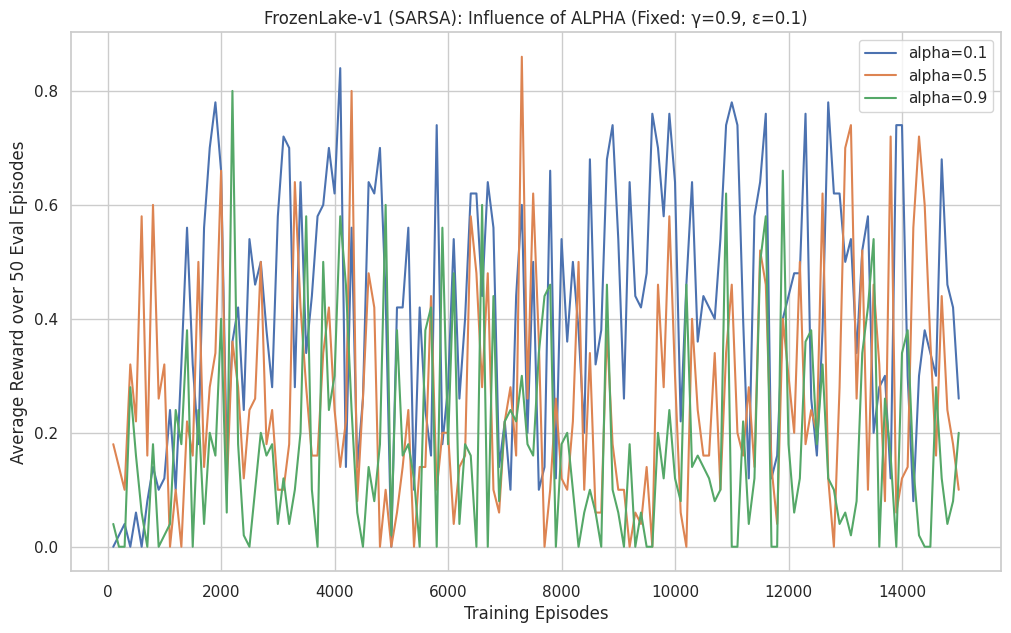

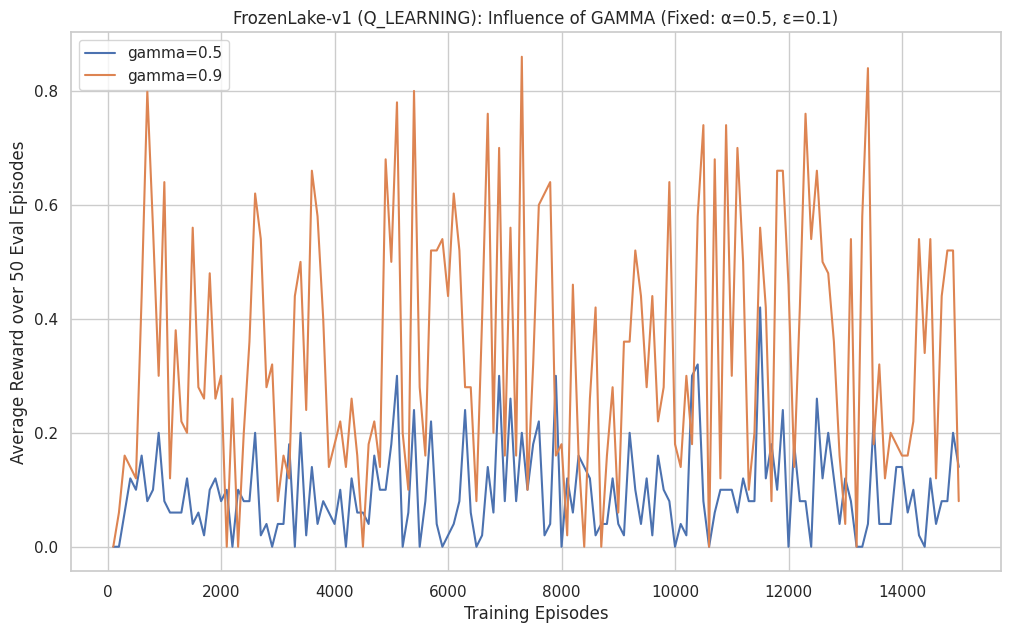

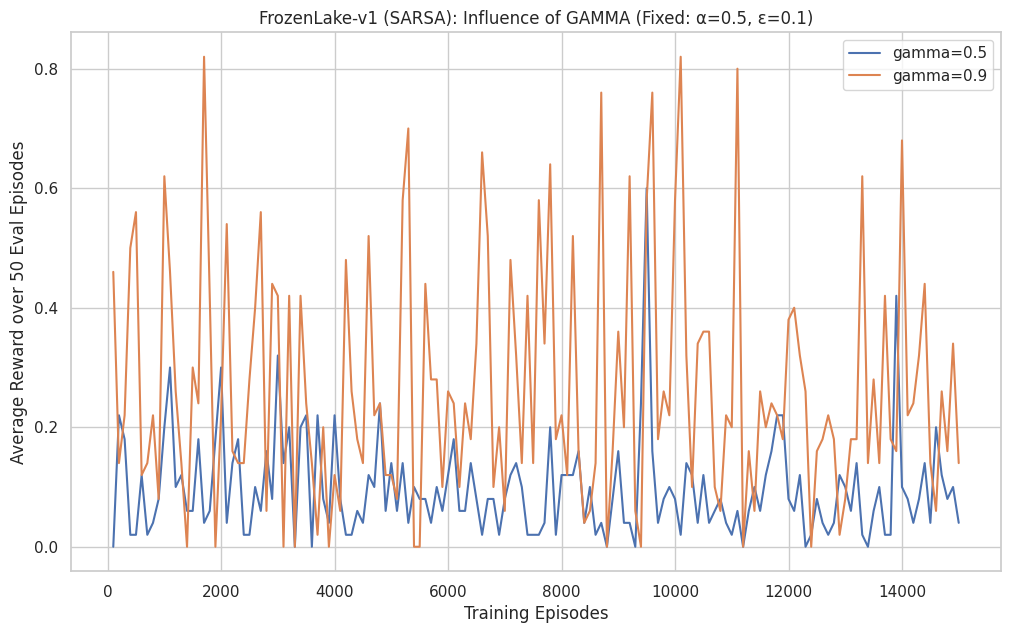

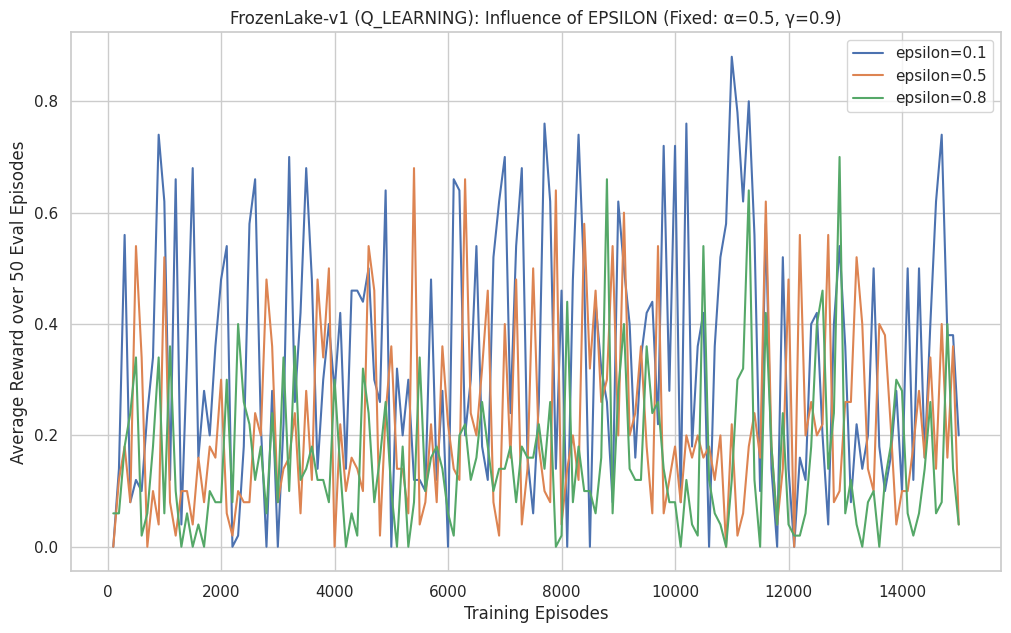

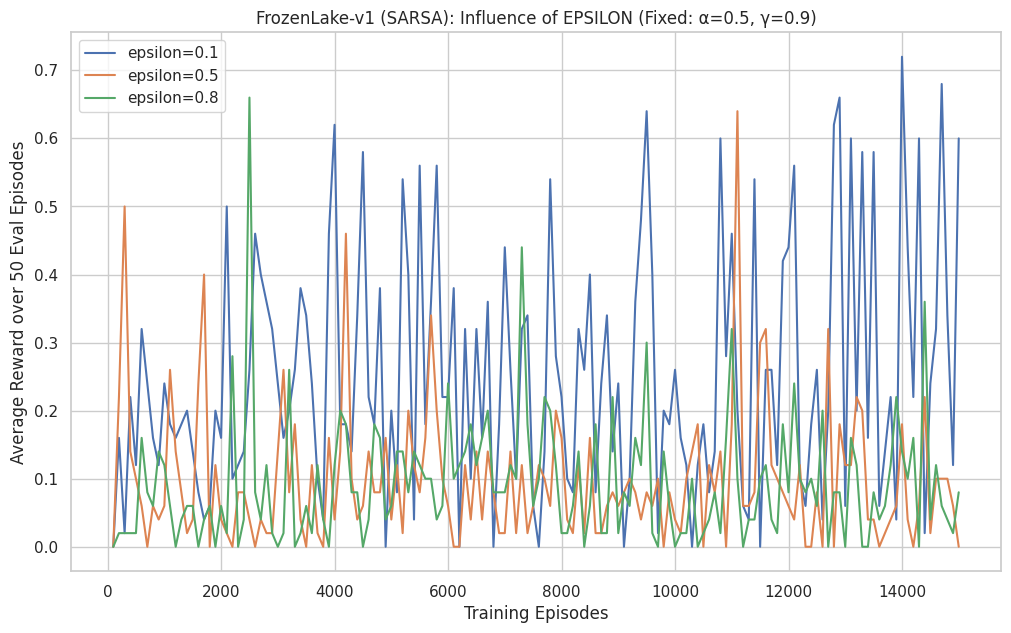

In [ ]:
for env_name in ENV_NAMES:
    print(f"\n----- Visualizing Results for: {env_name} -----")

    # Plot Baseline Comparison
    plot_comparison(results, env_name, title_suffix=" (Baseline)")

    # Plot Influence of Alpha
    fixed_alpha_params_ql = {'γ': BASELINE_GAMMA, 'ε': BASELINE_EPSILON}
    plot_parameter_influence(results, env_name, 'q_learning', 'alpha', fixed_alpha_params_ql)
    fixed_alpha_params_sarsa = {'γ': BASELINE_GAMMA, 'ε': BASELINE_EPSILON}
    plot_parameter_influence(results, env_name, 'sarsa', 'alpha', fixed_alpha_params_sarsa)

    # Plot Influence of Gamma
    fixed_gamma_params_ql = {'α': BASELINE_ALPHA, 'ε': BASELINE_EPSILON}
    plot_parameter_influence(results, env_name, 'q_learning', 'gamma', fixed_gamma_params_ql)
    fixed_gamma_params_sarsa = {'α': BASELINE_ALPHA, 'ε': BASELINE_EPSILON}
    plot_parameter_influence(results, env_name, 'sarsa', 'gamma', fixed_gamma_params_sarsa)

    # Plot Influence of Epsilon
    fixed_epsilon_params_ql = {'α': BASELINE_ALPHA, 'γ': BASELINE_GAMMA}
    plot_parameter_influence(results, env_name, 'q_learning', 'epsilon', fixed_epsilon_params_ql)
    fixed_epsilon_params_sarsa = {'α': BASELINE_ALPHA, 'γ': BASELINE_GAMMA}
    plot_parameter_influence(results, env_name, 'sarsa', 'epsilon', fixed_epsilon_params_sarsa)